In [13]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F

In [3]:
#Load dataset
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100.0%


Extracting F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST\raw


3.5%

100.6%
0.0%

Extracting F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST\raw



100.0%


Extracting F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST\raw



119.3%

Extracting F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST\raw



In [4]:

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

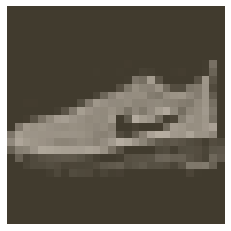

In [12]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [39]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [512, 256, 128, 64]
output_size   = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(hidden_sizes[3], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)


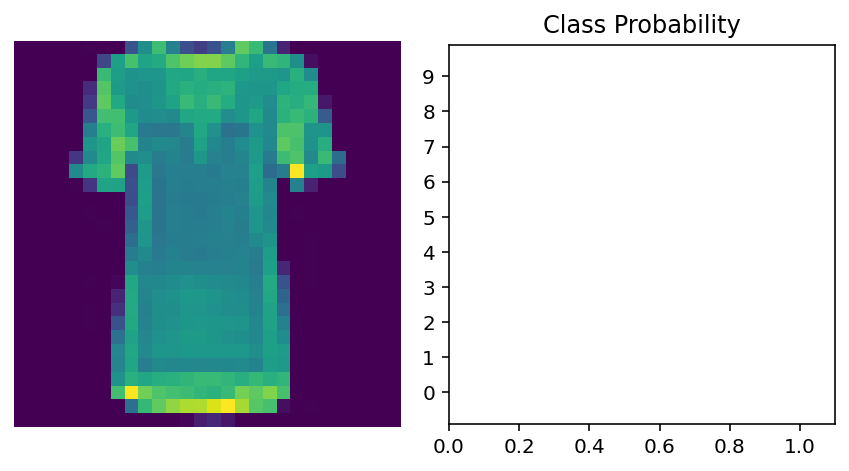

In [40]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

In [30]:
## TODO: Your training loop here
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
epochs = 10
#print_every = 40

for e in range(epochs):
    # running_loss = 0
    #print(f"Epoch: {e+1}/{epochs}")
    train_correct_guess = 0
    train_total = 0

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        model.train()

        optimizer.zero_grad()
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        train_pred_y = torch.max(output, 1)[1].data.squeeze()
        train_correct_guess += (train_pred_y == labels).float().sum()
        train_total += len(labels)
        accuracy = (train_pred_y == labels).sum().item() / float(labels.size(0))

    print(f'epoch {e+1} done: train accuracy of {(train_correct_guess/train_total).float()}')
    
    model.eval()
    with torch.no_grad():
        correct_guess = 0
        total = 0
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 784)
            test_output = model.forward(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct_guess += (pred_y == labels).float().sum()
            total += len(labels)
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print(f'epoch {e+1} done: test accuracy of {(correct_guess/total).float()}')
    

epoch 1 done: train accuracy of 0.14139999449253082
epoch 1 done: test accuracy of 0.2542000114917755
epoch 2 done: train accuracy of 0.2487500011920929
epoch 2 done: test accuracy of 0.3176000118255615
epoch 3 done: train accuracy of 0.2893333435058594
epoch 3 done: test accuracy of 0.33869999647140503
epoch 4 done: train accuracy of 0.310699999332428
epoch 4 done: test accuracy of 0.3776000142097473
epoch 5 done: train accuracy of 0.3190833330154419
epoch 5 done: test accuracy of 0.35839998722076416
epoch 6 done: train accuracy of 0.3155499994754791
epoch 6 done: test accuracy of 0.38499999046325684
epoch 7 done: train accuracy of 0.4073333442211151
epoch 7 done: test accuracy of 0.5062999725341797
epoch 8 done: train accuracy of 0.47839999198913574
epoch 8 done: test accuracy of 0.5631999969482422
epoch 9 done: train accuracy of 0.527483344078064
epoch 9 done: test accuracy of 0.6122999787330627
epoch 10 done: train accuracy of 0.5658166408538818
epoch 10 done: test accuracy of 0.63

In [ ]:
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

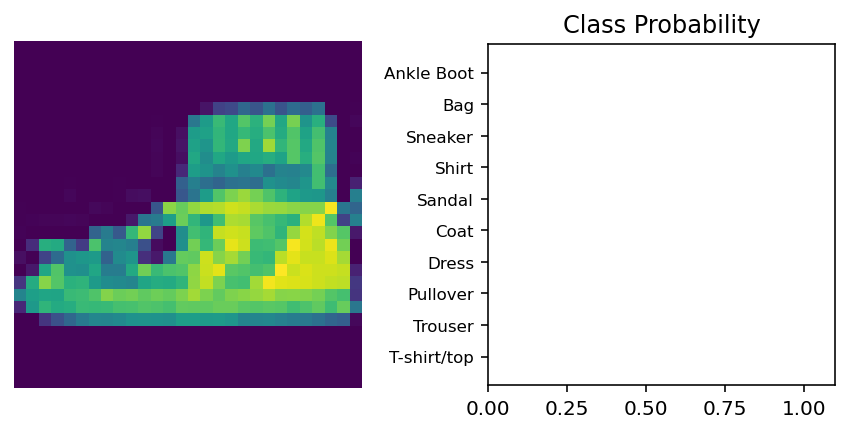

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
images.resize_(images.shape[0], 1, 784)
img = images[1]

ps = model(img) # ps stands for probabilities: your model should return values between 0 and 1
# that sums to 1. A softmax does this job!

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')